# Load Packages

In [1]:
using Dates, Roots, Optim

include("printmat.jl")

printlnPs (generic function with 2 methods)

In [3]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Utility Function

Recall: the CRRA utility function is $U(x) = \frac{x^{1-\gamma}}{1-\gamma}$

In [4]:
U(x,γ) =  x^(1-γ)/(1-γ)    #CRRA utility function, γ is the risk aversion

U (generic function with 1 method)

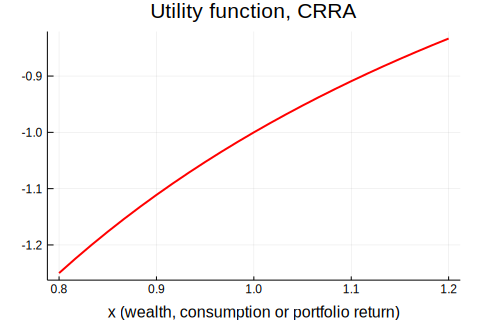

In [5]:
x = range(0.8,stop=1.2,length=25)

p1 = plot(x,U.(x,2),color=:red,linewidth=2,legend=false)
title!("Utility function, CRRA")
xlabel!("x (wealth, consumption or portfolio return)")

# Expected Utility

Recall: if $\pi_s$ is the probability of outcome $x_s$ and there are $S$ possible outcomes, then

$\text{E}U(x) = \sum\nolimits_{s=1}^{S} \pi_{s}U(x_s)$

In [6]:
EU(x,π,γ) = sum(π.*U.(x,γ))               #expected utility

EU (generic function with 1 method)

In [7]:
x₁ = 0.85               #possible outcomes
x₂ = 1.15
π₁ = 0.5                #probabilities of outcomes 
π₂ = 1 - π₁

xx = [x₁      x₂     ;
      U(x₁,2) U(x₂,2)]
println("Possible wealth levels (first row) and the corresponding utility (2nd)")
printmat(xx)

Ex = sum([π₁ π₂].*[x₁ x₂])
printlnPs("Expected wealth is: ",Ex)

ExpUtil = EU([x₁ x₂],[π₁ π₂],2)
printlnPs("Expected utility: ",ExpUtil)

Possible wealth levels (first row) and the corresponding utility (2nd)
     0.850     1.150
    -1.176    -0.870

Expected wealth is:      1.000
Expected utility:     -1.023


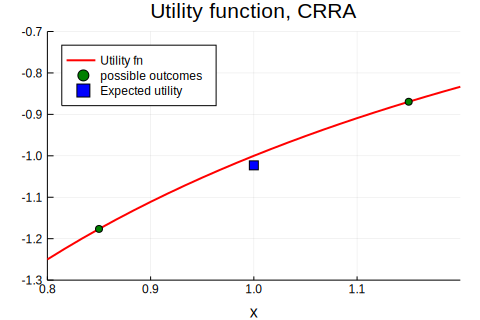

In [8]:
p1 = plot(x,U.(x,2),color=:red,linewidth=2,label="Utility fn")
scatter!([x₁;x₂],U.([x₁;x₂],2),color=:green,label="possible outcomes  ")
scatter!([Ex],[ExpUtil],color=:blue,marker=:rect,label="Expected utility ")
plot!(xlim=extrema(x),ylim=(-1.3,-0.7),legend=:topleft)
title!("Utility function, CRRA")
xlabel!("x")
ylabel!("")

# Certainty Equivalent

Recall: the certainty equivalent (here denoted $P$) is the sure (non-stochastic) value that solves 

$U(P) = \text{E}U(x)$

The code below solves for $P$ by a numerial search (actually, we could do it analytically in this case). This is applied to different values of risk aversion.

Notice that the expected wealth level in this example is 1.

In [9]:
println("risk aversion and certainly equivalent (cf. Ex = $Ex)")
γM = [0.0001;2;5;10;25]
for γ in γM
    local ceq
    ceq = find_zero(P->EU([x₁ x₂],[π₁ π₂],γ) - U(P,γ),(0.5,1.5))
    printlnPs([γ ceq])
end

risk aversion and certainly equivalent (cf. Ex = 1.0)
     0.000     1.000
     2.000     0.978
     5.000     0.947
    10.000     0.912
    25.000     0.875


# Portfolio Choice with One Risky Asset

Recall: the investor solves $\max\nolimits_{v}\text{E}\ln (1+R_{p})\text{, with }R_{p}=vR_{1} + (1-v)R_{f}$

In the example below, there are two possible outcomes for $R_{1}$ (-0.2 and 0.5) with equal probabilities.

This particular problem can be solved by pen and paper, but it becomes very difficult when the number of states increase - and even worse when there are many assets. We therefore apply a numerical optimization algorithm.

In [10]:
"""
    EUc

Calculate expected utility (log(Rp+1)) from investing into one risky and one riskfree asset

v: scalar
π: S vector (S possible "states")
R: S vector, return of the risky asset in different states
Rf: scalar, riskfree rate
"""
function EUc(v,π,Re,Rf)             #expected utility, utility fn is logarithmic
    R  = Re .+ Rf                   
    Rp = v*R .+ (1-v)*Rf            #portfolio return
    EU = sum(π .* log.(1.0.+Rp))    #expected utility
    return EU
end

EUc (generic function with 1 method)

In [11]:
v = range(-1,stop=1,length=101)    #try different weights on risky asset
L = length(v)
EUv = fill(NaN,L)
for i = 1:L
    EUv[i] = EUc(v[i],[0.5;0.5],[-0.3;0.4],0.1)
end

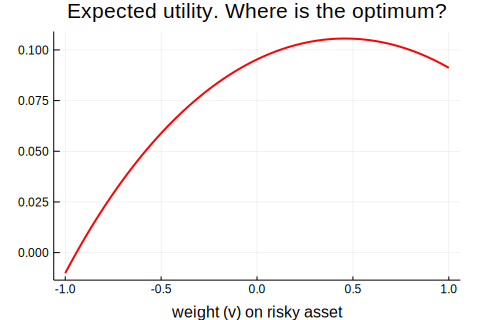

In [12]:
p1 = plot(v,EUv,color=:red,linewidth=2,legend=false)
title!("Expected utility. Where is the optimum?")
xlabel!("weight (v) on risky asset")

In [13]:
#minimize -EU()
Sol = optimize(v-> -EUc(v,[0.5;0.5],[-0.3;0.4],0.1),-1,1)   #try v values between -1 and 1
printlnPs("argmin -EUc(): ",Optim.minimizer(Sol))

println("Compare with the figure")

argmin -EUc():      0.458
Compare with the figure


# Portfolio Choice with Several Risky Assets

This optimization problem has two risky assets and a general CRRA utility function. Numerical optimization is still easy.

In [14]:
"""
    EUe

Calculate expected utility from investing into n risky assets and one riskfree asset

v:  n vector (weights on the n risky assets)
π:  S vector (S possible "states")
R:  nxS matrix, each column is the n vector of returns in one of the states
Rf: scalar, riskfree rate
γ:  scalar, risk aversion
"""
function EUe(v,π,R,Rf,γ)                
    Rp = v'R .+ (1-sum(v))*Rf           #portfolio return, row vector (different states)
    Rp = vec(Rp)                        #turn Rp into a vector
    EUNeg = -EU(1.0.+Rp,π,γ)            #since optimize() minimizes
    return EUNeg
end

EUe (generic function with 1 method)

In [15]:
ROutComes = [-0.03 0.08 0.20;           #2 assets, 3 states
             -0.04 0.22 0.15]           #cell[i,j] is asset i in state j
π = [1/3;1/3;1/3]
Rf = 0.065
Sol = optimize(v->EUe(v,π,ROutComes,Rf,5),[-0.6;1.2])         
printlnPs("optimal weights from max EUe(): ",Optim.minimizer(Sol))

optimal weights from max EUe():     -0.726     1.317


# From Chapter on Mean-Variance Analysis

In [16]:
function MVCalc(mustar,μ,Σ)           #calculates the std of a portfolio on MVF of risky assets
    n    = length(μ)
    oneV = ones(n) 
    Σ_1  = inv(Σ)
    A    = μ'Σ_1*μ
    B    = μ'Σ_1*oneV
    C    = oneV'Σ_1*oneV
    λ    = (C*mustar - B)/(A*C-B^2)
    δ    = (A-B*mustar)/(A*C-B^2)
    w    = Σ_1 *(μ*λ + oneV*δ)
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

function MVCalcRf(mustar,μ,Σ,Rf)           #calculates the std of a portfolio on MVF
    n   = length(μ)
    μe  = μ .- Rf                          #excess returns            
    Σ_1 = inv(Σ)
    w   = (mustar-Rf)/(μe'Σ_1*μe) * Σ_1*μe
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

MVCalcRf (generic function with 1 method)

# Mean-Variance and the Telser Criterion

Let $\mu$ be a vector of expected returns and $\Sigma$ be the covariance matrix of the investible asssets.

The Telser criterion solves the problem

$\max_{v} \mu_{p} \> \text{ subject to} \>  \text{VaR}_{95\%} < 0.1$,

where $\mu_{p} = v'\mu+(1-v)R_f$ is the expected portfolio return.

If the returns are normally distributed then 

$\text{VaR}_{95\%} = -(\mu_p - 1.64\sigma_p)$,

where $\sigma_p = \sqrt{v'\Sigma v}$ is the standard deviation of the portfolio return.

The figure below illustrates that the optimal portfolio is on the CLM (when the returns are normally distributed)

In [17]:
μ = [9; 6]/100                     #means
Σ = [ 256  0;
      0    144]/10000
Rf = 1/100

mustar  = range(Rf,stop=0.1,length=101)
L       = length(mustar)
StdRp   = fill(NaN,L)
StdRpRf = fill(NaN,L)
for i = 1:L
    StdRp[i]   = MVCalc(mustar[i],μ,Σ)[1]
    StdRpRf[i] = MVCalcRf(mustar[i],μ,Σ,Rf)[1]
end   

VaRRestr = -0.1 .+ 1.64*StdRpRf

println()

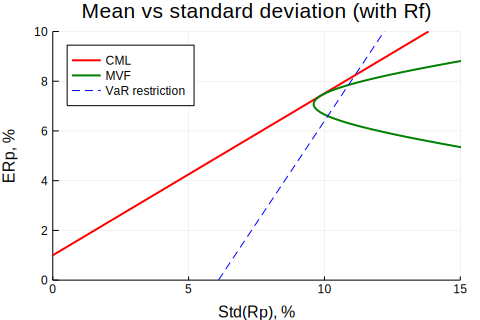

In [18]:
p1= plot(StdRpRf*100,mustar*100,color=:red,linewidth=2,label="CML")
plot!(StdRp*100,mustar*100,color=:green,linewidth=2,label="MVF")
plot!(StdRpRf*100,VaRRestr*100,line=:dash,color=:blue,label="VaR restriction")
plot!(xlim=(0,15),ylim=(0,10),legend=:topleft)
title!("Mean vs standard deviation (with Rf)")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")